In [2]:
!pip install -q gdown polars lightgbm scikit-learn imbalanced-learn matplotlib

# kalian download semua file dari gdrive dibawah lalu buat folder (ex. midterm_folder)
!gdown --folder 19Mgwv5BTZKH7adrfddTluWtOOcC6b39S?hl=ID -O midterm_folder

Retrieving folder contents
Processing file 1OoF1exf6JQsIdQfrP66vMPe6A7J-LXJz test_transaction.csv
Processing file 1VCRJDI_ztVa42qn2uJCQVAHpEyZP_xdl train_transaction.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1OoF1exf6JQsIdQfrP66vMPe6A7J-LXJz
From (redirected): https://drive.google.com/uc?id=1OoF1exf6JQsIdQfrP66vMPe6A7J-LXJz&confirm=t&uuid=186f4b6b-37d1-4291-9691-ac0449745b04
To: /content/midterm_folder/test_transaction.csv
100% 613M/613M [00:03<00:00, 185MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1VCRJDI_ztVa42qn2uJCQVAHpEyZP_xdl
From (redirected): https://drive.google.com/uc?id=1VCRJDI_ztVa42qn2uJCQVAHpEyZP_xdl&confirm=t&uuid=6eefe117-2953-4785-acdd-5cb461078497
To: /content/midterm_folder/train_transaction.csv
100% 683M/683M [00:02<00:00, 238MB/s]
Download completed


library digunakan untuk memproses dataset fraud yang besar secara efisien. gdown mengunduh data gdrive, polars mempercepat loading, LightGBM memodelkan fraud dengan akurat, scikit-learn menangani preprocessing dan evaluasi, imbalanced-learn mengatasi data tidak seimbang, dan matplotlib membuat visualisasi. seluruh library ini dipilih agar proses berjalan cepat, hemat memori, dan stabil

In [3]:
import os, gc, time
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

meng import semua library untuk loading data, eksplorasi, preprocessing, training model ML, dan evaluasi

In [4]:
#auto detect files
def find_file(folder, key):
    for f in os.listdir(folder):
        if key in f:
            return os.path.join(folder, f)
    return None

fungsi `find_file()` mencari file yang mengandung kata tertentu (train_transaction, test_transaction,
dst)

In [5]:
BASE_DIR = "midterm_folder"
train_tx_path = find_file(BASE_DIR, "train_transaction")
test_tx_path  = find_file(BASE_DIR, "test_transaction")
train_id_path = find_file(BASE_DIR, "train_identity")
test_id_path  = find_file(BASE_DIR, "test_identity")

In [6]:
print("Detected files:")
print(train_tx_path)
print(test_tx_path)
print(train_id_path)
print(test_id_path)

Detected files:
midterm_folder/train_transaction.csv
midterm_folder/test_transaction.csv
None
None


In [7]:
#load data
t0 = time.time()
train_tx = pl.read_csv(train_tx_path, low_memory=True)
test_tx  = pl.read_csv(test_tx_path, low_memory=True)
print(f"Loaded in {time.time()-t0:.1f}s")

Loaded in 31.7s


data transaksi di load menggunakan **polars**, agar jauh lebih cepat dan hemat RAM dibanding
pandas

In [12]:
if train_id_path:
    train_id = pl.read_csv(train_id_path)
    train = train_tx.join(train_id, on="TransactionID", how="left")
else:
    train = train_tx

print("Train shape:", train.shape)

Train shape: (590540, 394)


In [13]:
if test_id_path:
    test_id = pl.read_csv(test_id_path)
    test = test_tx.join(test_id, on="TransactionID", how="left")
else:
    test = test_tx

print("Test shape:", test.shape)

Test shape: (506691, 393)


In [14]:
def downcast(df):
    for c in df.columns:
        if df[c].dtype == pl.Float64:
            df = df.with_columns(pl.col(c).cast(pl.Float32))
        if df[c].dtype == pl.Int64:
            df = df.with_columns(pl.col(c).cast(pl.Int32))
    return df

In [15]:
#downcast and covert to pandas
train = downcast(train).to_pandas()
test  = downcast(test).to_pandas()

gc.collect()

0

ini adalah downcast dilakukan untuk mengecilkan ukuran tipe data, lalu data dikonversi ke pandas agar bisa dipakai ML sklearn

In [16]:
print("\n===== IEDA: info dataset =====")
print(train.info())


===== IEDA: info dataset =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float32(376), int32(4), object(14)
memory usage: 919.1+ MB
None


In [17]:
print("\nFraud distribution:")
print(train["isFraud"].value_counts(normalize=True))


Fraud distribution:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


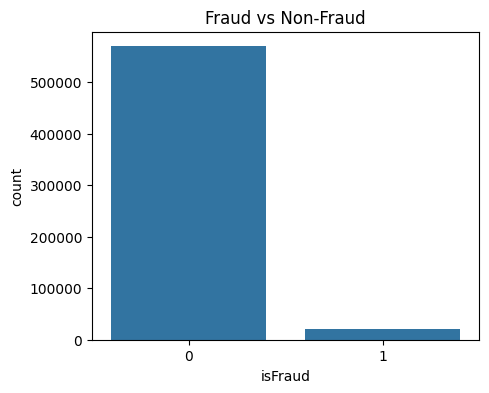

In [18]:
plt.figure(figsize=(5,4))
sns.countplot(x=train["isFraud"])
plt.title("Fraud vs Non-Fraud")
plt.show()

ini IEDA sederhana dimana info dataset, jumlah fraud vs non-fraud, dan visualisasi imbalance

In [19]:
#preprocessing
#drop constant
const_cols = train.columns[train.nunique() <= 1].tolist()
train.drop(columns=const_cols, inplace=True, errors="ignore")
test.drop(columns=const_cols, inplace=True, errors="ignore")

In [20]:
#label encoding kategori
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()
le = LabelEncoder()

In [21]:
for col in cat_cols:
    both = pd.concat([train[col].fillna("MISSING"), test[col].fillna("MISSING")])
    le.fit(both.astype(str))

    train[col] = le.transform(train[col].fillna("MISSING").astype(str))
    test[col]  = le.transform(test[col].fillna("MISSING").astype(str))

In [22]:
#fill numeric missing (menggunakan median)
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["isFraud", "TransactionID"]]

In [27]:
for col in num_cols:
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col]  = test[col].fillna(med)

semua kolom konstan dihapus, kategori diencode, nilai kosong diisi median agar aman untuk model LightGBM

In [33]:
#split feature label
X = train.drop(columns=["isFraud", "TransactionID"])
y = train["isFraud"].astype(int)

test_ids = test["TransactionID"]
X_test_final = test.drop(columns=["TransactionID"], errors="ignore")

memisahkan fitur dan label untuk model klasifikasi fraud

In [34]:
#train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Validation fraud rate:", y_train.mean())

Train size: (472432, 392)
Validation fraud rate: 0.03498916246147594


split dilakukan secara stratified agar perbandingan fraud tetap seimbang di train dan validation

In [35]:
#handle imbalance
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X_train, y_train)
print("Balanced data shape:", X_bal.shape)

Balanced data shape: (33060, 392)


karena fraud sangat sedikit, dilakukan undersampling agar model tidak bias ke kelas mayoritas

In [36]:
param_dist = {
    "num_leaves": [31, 63],
    "learning_rate": [0.1, 0.05],
    "n_estimators": [200, 400],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
}

In [37]:
#hyperparameter tuning
search = RandomizedSearchCV(
    estimator=LGBMClassifier(objective="binary", random_state=42),
    param_distributions=param_dist,
    n_iter=4,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

mencari kombinasi parameter terbaik LightGBM menggunakan RandomizedSearchCV dengan biaya komputasi ringan

In [38]:
search.fit(X_bal, y_bal)
best_params = search.best_params_
print("BEST PARAMS:", best_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Number of positive: 16530, number of negative: 16530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29901
[LightGBM] [Info] Number of data points in the train set: 33060, number of used features: 379
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
BEST PARAMS: {'subsample': 0.7, 'num_leaves': 63, 'n_estimators': 200, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [39]:
#final model training
model = LGBMClassifier(
    objective="binary",
    random_state=42,
    class_weight="balanced",
    **best_params
)

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.135723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36499
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 390
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, n_estimators=200,
               num_leaves=63, objective='binary', random_state=42,
               subsample=0.7)

model LightGBM dilatih penuh menggunakan semua sample train (tanpa undersampling) untuk
performa maksimal

In [40]:
val_prob = model.predict_proba(X_val)[:, 1]
val_pred = (val_prob >= 0.5).astype(int)

In [41]:
print("\n===== VALIDATION METRICS =====")
print("ROC-AUC:", roc_auc_score(y_val, val_prob))
print("PR-AUC :", average_precision_score(y_val, val_prob))
print("\nClassification Report:")
print(classification_report(y_val, val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, val_pred))


===== VALIDATION METRICS =====
ROC-AUC: 0.9562976650414091
PR-AUC : 0.7235596316082114

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    113975
           1       0.31      0.84      0.45      4133

    accuracy                           0.93    118108
   macro avg       0.65      0.89      0.71    118108
weighted avg       0.97      0.93      0.94    118108


Confusion Matrix:
[[106349   7626]
 [   673   3460]]


In [42]:
#predict and submission
missing_cols = set(X.columns) - set(X_test_final.columns)
for c in missing_cols:
    X_test_final[c] = 0

X_test_final = X_test_final[X.columns]

In [43]:
test_prob = model.predict_proba(X_test_final)[:, 1]

In [44]:
submission = pd.DataFrame({
    "TransactionID": test_ids,
    "isFraud": test_prob
})

os.makedirs("submission", exist_ok=True)
submission.to_csv("submission/fraud_ml_submission.csv", index=False)

hasil prediksi probabilitas fraud disimpan sebagai file submission CSV

In [45]:
print("\nSubmission saved > submission/fraud_ml_submission.csv")
submission.head()


Submission saved > submission/fraud_ml_submission.csv


,TransactionID,isFraud
0,3663549,0.043952
1,3663550,0.027614
2,3663551,0.026666
3,3663552,0.024986
4,3663553,0.020568
